In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt

To convert the ['Date of Travrel'] values into date format, i used this function authored by @alaudet https://gist.github.com/alaudet/307ac574973028497d083f6d43575214

In [2]:
def date_to_string(digit_date):
    new_form = []
    for d in digit_date:
        try:
            x = datetime.date(1899,12,30) + datetime.timedelta(days=float(d))
            new_form.append(x.strftime('%Y-%m-%d'))
        except:
            new_form.append('n/a')
    return new_form

# Import CSV data

In [3]:
cab_data = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv')
# the date are converted here, and there's no null value.
cab_data['Date of Travel'] = date_to_string(cab_data['Date of Travel'])
# cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel'], errors='coerce')
cab_data.head()


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [4]:
list = []
# cab_data_company = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv', usecols=['Company'])
for name in cab_data['Company']:
    if list != []:
        if name in list:
            continue
        else:
            list.append(name)
    elif list == []:
        list.append(name)
# print(list)
print('The companies we are assessing are ' + str(list))

The companies we are assessing are ['Pink Cab', 'Yellow Cab']


In [5]:
city = pd.read_csv('~/dg_intern/DataSets/City.csv')
print('We have data collected from ' + str(len(city['City'])) + ' cities in total.')
city.head()

We have data collected from 20 cities in total.


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [6]:
customer_id = pd.read_csv('~/dg_intern/DataSets/Customer_ID.csv')
customer_id.head()


,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [7]:

transaction = pd.read_csv('~/dg_intern/DataSets/Transaction_ID.csv')
transaction.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


# Establish the relational database

In [8]:
output1 = pd.merge(cab_data, transaction, 
                   on='Transaction ID', 
                   how='inner')
cab_trans_customer = pd.merge(output1, customer_id, 
                   on='Customer ID', 
                   how='inner')
cab_trans_customer.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
3,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
4,10320494,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237


# General information

## annual profit

In [11]:
profit_pi = [[],[],[]]
profit_ye = [[],[],[]]

# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    if name == 'Pink Cab':
        if cab_trans_customer['Date of Travel'][i][:4] == '2016':
            profit_pi[0].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2017':
            profit_pi[1].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2018':
            profit_pi[2].append(a)
    elif name == 'Yellow Cab':
        if cab_trans_customer['Date of Travel'][i][:4] == '2016':
            profit_ye[0].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2017':
            profit_ye[1].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2018':
            profit_ye[2].append(a)
    else:
        print('missing')
        

In [12]:
ann_profit = np.ma.zeros((2, 3))
ann_profit[0,0] = sum(profit_pi[0])
ann_profit[0,1] = sum(profit_pi[1])
ann_profit[0,2] = sum(profit_pi[2])
ann_profit[1,0] = sum(profit_ye[0])
ann_profit[1,1] = sum(profit_ye[1])
ann_profit[1,2] = sum(profit_ye[2])


## seasonal profits

In [9]:
profit_pi_sea = [[0]*12 for i in range(3)]
profit_ye_sea = [[0]*12 for i in range(3)]

# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    mon = 10* int(cab_trans_customer['Date of Travel'][i][5]) + int(cab_trans_customer['Date of Travel'][i][6])
    if name == 'Pink Cab':
        profit_pi_sea[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][mon-1] += a
    elif name == 'Yellow Cab':
        profit_ye_sea[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][mon-1] += a
    else:
        print('missing')
        
sea_profit = np.ma.empty((2,3,4)) # two companies, 3 years, 4 seasons
sea_profit[0,0,0] = sum(profit_pi_sea[0][:3])
sea_profit[0,0,1] = sum(profit_pi_sea[0][3:6])
sea_profit[0,0,2] = sum(profit_pi_sea[0][6:9])
sea_profit[0,0,3] = sum(profit_pi_sea[0][9:12])
sea_profit[0,1,0] = sum(profit_pi_sea[1][:3])
sea_profit[0,1,1] = sum(profit_pi_sea[1][3:6])
sea_profit[0,1,2] = sum(profit_pi_sea[1][6:9])
sea_profit[0,1,3] = sum(profit_pi_sea[1][9:12])
sea_profit[0,2,0] = sum(profit_pi_sea[2][:3])
sea_profit[0,2,1] = sum(profit_pi_sea[2][3:6])
sea_profit[0,2,2] = sum(profit_pi_sea[2][6:9])
sea_profit[0,2,3] = sum(profit_pi_sea[2][9:12])

sea_profit[1,0,0] = sum(profit_ye_sea[0][:3])
sea_profit[1,0,1] = sum(profit_ye_sea[0][3:6])
sea_profit[1,0,2] = sum(profit_ye_sea[0][6:9])
sea_profit[1,0,3] = sum(profit_ye_sea[0][9:12])
sea_profit[1,1,0] = sum(profit_ye_sea[1][:3])
sea_profit[1,1,1] = sum(profit_ye_sea[1][3:6])
sea_profit[1,1,2] = sum(profit_ye_sea[1][6:9])
sea_profit[1,1,3] = sum(profit_ye_sea[1][9:12])
sea_profit[1,2,0] = sum(profit_ye_sea[2][:3])
sea_profit[1,2,1] = sum(profit_ye_sea[2][3:6])
sea_profit[1,2,2] = sum(profit_ye_sea[2][6:9])
sea_profit[1,2,3] = sum(profit_ye_sea[2][9:12])


## portion of seasonal profits in total

In [13]:
sea_ann_profit = np.ma.empty((2, 4))
for i in range(2):
    for sea in range(4):
        sum_ann_profit = sum(ann_profit[i, :])
        sum_sea_profit = sum(sea_profit[i, :, sea])
        sea_ann_profit[i, sea] = sum_sea_profit / sum_ann_profit

## portion of seasonal profits of each year

In [14]:
for i in range(2):
    for iyear in range(3):
        sea_profit[i, iyear, :] = sea_profit[i, iyear, :] / ann_profit[i,iyear]

## plots

In [25]:
b1 = np.arange(4)
br1 = [x*barWidth for x in b1]
br2 = [2 + x*barWidth for x in b1]
print(br1)
print(br2)

[0.0, 0.3, 0.6, 0.8999999999999999]
[2.0, 2.3, 2.6, 2.9]


Annual Profits of from 2016 to 2018
[[ 1713511.224       2033654.90800001  1560162.18899998]
 [13926995.43159986 16575977.96800002 13517399.77119991]]


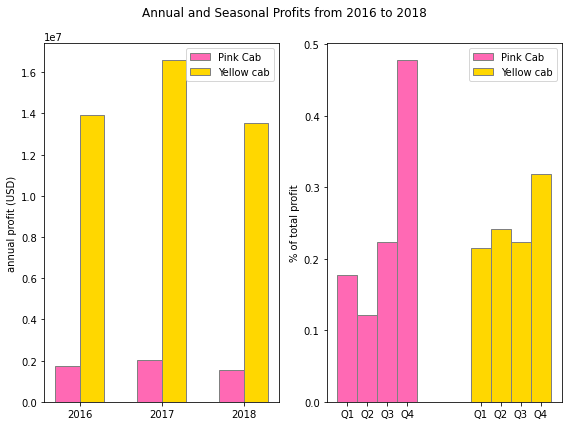

In [28]:
print('Annual Profits of from 2016 to 2018')
print(ann_profit)
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Annual and Seasonal Profits from 2016 to 2018')
axs[0].bar(br1, ann_profit[0], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[0].bar(br2, ann_profit[1], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs[0].set_ylabel('annual profit (USD)')

# sea_ann_profit
b1 = np.arange(4)
br1 = [x*barWidth for x in b1]
br2 = [2 + x*barWidth for x in b1]

axs[1].bar(br1, sea_ann_profit[0], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
axs[1].bar(br2, sea_ann_profit[1], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_xticks([0.0, 0.3, 0.6, 0.8999999999999999,2.0, 2.3, 2.6, 2.9], ['Q1','Q2','Q3','Q4', 'Q1','Q2','Q3','Q4'])
axs[1].set_ylabel('% of total profit')

fig.tight_layout()



label the percentage, group by company

## profitable days

## annual customers